# Q-learning Algorithms

> With Implementations of key ideas


In [9]:
#hide
from IPython.display import Image, display
dest = '/Users/vinay/fastrl/images/'

## Neural Nets with Q-LEARNING

Reference : [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)

`Key Questions` :

1.**Can we use neural nets in RL setting where the observations are correlated and Non-stationary(non-iid) ?**

`solution` : Experiance Replay

## Context

In [21]:
#hide
psuedo_code = Image(dest+'Screenshot 2020-02-21 at 12.28.01 PM.png')

The key algorithm introduced in the [paper](https://arxiv.org/abs/1312.5602) is summarized below but we need necessary context before naively implementing it. Let us start with our knowledge of using Deep Nets in Supervised setting, and try to formulate the problem in similar context :

From each state the agent encounters we want the agent to output a probability distribution over all possible actions, which when sampled from results in optimal return. So, if we can have access to the labels(optimal actions) from each state we can easily create a loss function and proceed with SGD over all the states.

Here's a simple approach for bootstrapping the labels:


1. Play the episode multiple times.

2. Record the returns

3. Choose the episodes with highest return. These might be the ones that the agent chanced upon good actions,so train on them.

### Cross-Entropy method 

In [183]:
#hide
import gym
import torch
import numpy as np
env_name = "CartPole-v0"
env = gym.make(env_name)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

Here we will use gym's [cartpole environment](https://gym.openai.com/envs/CartPole-v1/). Let's quickly check the average return under random actions. 

In [177]:
def play_episode(env,obs_acts,sampler):
    ob = env.reset()
    done = False
    rewards = 0
    while not done:
        acts = obs_acts(ob)
        actn = sampler(acts)
        next_obs, reward,done, _ = env.step(actn)
        rewards += reward
        ob = next_obs
    return rewards
    

Average return for 1000 episodes


In [178]:
np.mean([play_episode(env,lambda x : env.action_space.n,np.random.choice) for i in range(1000)])

22.295

In [179]:

import torch
import torch.nn as nn

obs_size = env.observation_space.shape[0]
hidden_size = 128

n_actions = env.action_space.n
net = nn.Sequential(nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions))


In [180]:
# Bootsrapping with the cross-entropy loss of best episodes.

from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(),lr=0.01)
obs_size = env.observation_space.shape[0]
hidden_size = obs_size*2
n_actions = env.action_space.n
sft_max = nn.Softmax(dim=1)
net = nn.Sequential(nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions))


def train(net,data,loss,optmizer):
    keys,labels = data
    pred_vals = net(keys)
    loss_v = loss(pred_vals,labels)
    optimizer.zero_grad()
    loss_v.backward()
    optimizer.step()
    

def categorical_sampler():
    def sampler(probs):
        return np.random.choice(len(probs),p=probs)
    return sampler

def play_episode(env,net,sampler):
    
    episode_step = namedtuple('episode_step',field_names=['obs','actn'])
    lis_steps = []
    episode = namedtuple('episode',field_names=['tot_return','lis_steps'])
    ob = env.reset()
    done = False
    rewards = 0
    while not done:
        acts = sft_max(net(torch.FloatTensor([ob])))
        #import pdb;pdb.set_trace()
        actn = sampler(acts.data.numpy()[0])
        lis_steps.append(episode_step(ob,actn))
        next_obs, reward,done, _ = env.step(actn)
        rewards += reward
        ob = next_obs
    return episode(rewards,lis_steps)
    

In [181]:
batch_size = 20
percentile = 75

sampler = categorical_sampler()
def get_batch(env,net,batch_size,sampler):
    batch = []
    while len(batch) < batch_size:
        episode = play_episode(env,net,sampler)
        batch.append(episode)
    return batch

In [182]:
batch = get_batch(env,net,10,sampler)
lis_returns = list(map(lambda x: x.tot_return,batch))
np.mean(lis_returns)

15.1

In [184]:
mean_returns = []
while True:
        batch = get_batch(env,net,10,sampler)
        lis_returns = list(map(lambda x: x.tot_return,batch))
        mean_return = np.mean(lis_returns)
        mean_returns.append(mean_return)
        ret_threshold = np.percentile(lis_returns,percentile)
        filtered_episodes = filter(lambda x : x.tot_return >= ret_threshold,batch)
        if mean_return > 199 or len(mean_returns) > 1000: 
            print('training complete')
            break
        else:
            for episode in filtered_episodes:
                obs  = list(map(lambda x: x.obs,episode.lis_steps))
                actns = list(map(lambda x: x.actn,episode.lis_steps))
                train(net,(torch.FloatTensor(obs),torch.LongTensor(actns)),loss,optimizer)
    
    

training complete


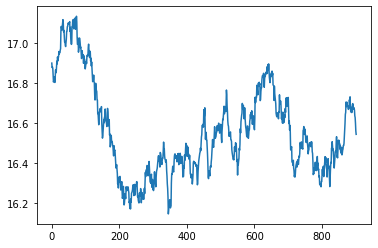

In [186]:
import matplotlib.pyplot as plt
plt.plot(moving_average(mean_returns,100))

## Psuedo-code

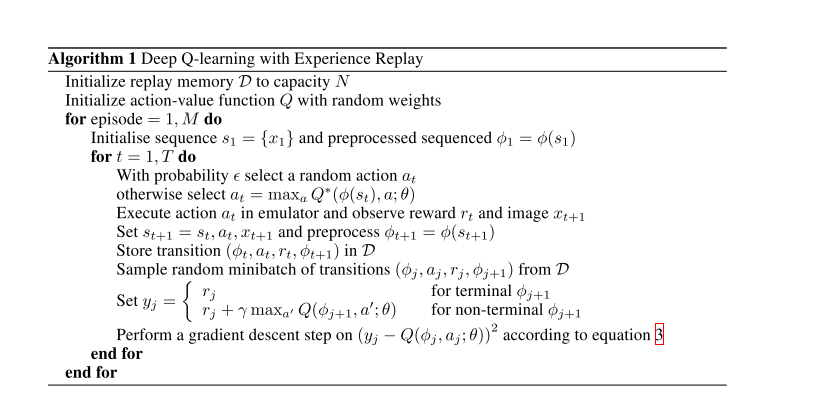

In [20]:
display(psuedo_code)